In [1]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTFeatureExtractor
import time

2024-10-13 12:50:38.797683: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-10-13 12:50:38.820963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.

To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

2024-10-13 12:50:39.266182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = []
        
        for class_idx, class_name in enumerate(os.listdir(img_dir)):
            class_folder = os.path.join(img_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.img_labels.append((img_path, class_idx))
                    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
dataper = [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3]

In [4]:
img_dir = '/home/buddha/Desktop/Satvik/PBC_dataset_normal_DIB/'  
dataset = CustomImageDataset(img_dir, transform=transform)

In [5]:
dataset_size = len(dataset)

In [6]:
test_size = 4000
validation_size = 1700
val_test_set, train_set_main = random_split(dataset, [validation_size+test_size, len(dataset) - (validation_size+test_size)])
val_set, test_set = random_split(val_test_set, [validation_size, test_size])

In [7]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = 0
        self.delta = delta

    def __call__(self, val_acc):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [8]:
time_data = {
    'Data Split' : [f'{i*100}%' for i in dataper],
    'Validation size' : [validation_size for i in range(len(dataper))],
    'Test size' : [test_size for i in range(len(dataper))],
    'Train size' : [int(i * dataset_size) for i in dataper],
    'Time Taken' : []
}
time_per_datasplit_per_epoch = []
save_model = []
train_loss_all =[]
train_acc_all= []
val_loss_all = []
val_acc_all = []

for i in dataper:
    train_loss_per =[]
    train_acc_per= []
    val_loss_per = []
    val_acc_per = []
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224',
        num_labels=8,  # 8 classes
        ignore_mismatched_sizes=True 
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_size = int(i * dataset_size)
    train_set, _ = random_split(train_set_main, [train_size, len(train_set_main) - train_size])
    print(len(train_set))
    batch_size = 8
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    import torch.optim as optim
    from tqdm import tqdm

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    time_epoch = []
    early_stopping = EarlyStopping(patience=3, delta=0.01)
    
    def train(model, train_loader, val_loader, epochs=15):
        for epoch in range(epochs):
            torch.cuda.empty_cache()
            t_epoch = time.time()
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in tqdm(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            scheduler.step()
            
            train_loss = running_loss / len(train_loader)
            train_acc = 100. * correct / total
            val_loss, val_acc = validate(model, val_loader)
            
            train_loss_per.append(train_loss)
            train_acc_per.append(train_acc)
            val_loss_per.append(val_loss)
            val_acc_per.append(val_acc)

            print(f'Epoch [{epoch+1}/{epochs}] '
                  f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% '
                  f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
            time_epoch.append(time.time() - t_epoch)

            early_stopping(val_acc)
            if early_stopping.early_stop:
                print("Early stopping triggered")
                break

    def validate(model, val_loader):
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        accuracy = 100. * correct / total

        return avg_val_loss, accuracy
    
    t0 = time.time()
    train(model, train_loader, val_loader, epochs=15)
    time_data['Time Taken'].append(time.time()-t0)
    train_loss_all.append(train_loss_per)
    train_acc_all.append(train_acc_per)
    val_loss_all.append(val_loss_per)
    val_acc_all.append(val_acc_per)
    time_per_datasplit_per_epoch.append(time_epoch)
    model.to('cpu')
    save_model.append(model)
    
    # Explicitly delete the model to free GPU memory
    del model
    # Clear the CUDA cache to release unused memory
    torch.cuda.empty_cache()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


170


100%|███████████████████████████████████████████| 22/22 [00:11<00:00,  1.94it/s]


Epoch [1/15] Train Loss: 1.3604 | Train Acc: 51.18% | Val Loss: 0.7058 | Val Acc: 77.59%


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.02it/s]


Epoch [2/15] Train Loss: 0.3592 | Train Acc: 88.82% | Val Loss: 0.5674 | Val Acc: 82.76%


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.03it/s]


Epoch [3/15] Train Loss: 0.1390 | Train Acc: 96.47% | Val Loss: 0.4221 | Val Acc: 85.88%


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.02it/s]


Epoch [4/15] Train Loss: 0.0320 | Train Acc: 100.00% | Val Loss: 0.2909 | Val Acc: 90.88%


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.04it/s]


Epoch [5/15] Train Loss: 0.0098 | Train Acc: 100.00% | Val Loss: 0.2656 | Val Acc: 91.82%


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.00it/s]


Epoch [6/15] Train Loss: 0.0062 | Train Acc: 100.00% | Val Loss: 0.2603 | Val Acc: 91.88%


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.04it/s]


Epoch [7/15] Train Loss: 0.0051 | Train Acc: 100.00% | Val Loss: 0.2567 | Val Acc: 92.00%


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.03it/s]


Epoch [8/15] Train Loss: 0.0045 | Train Acc: 100.00% | Val Loss: 0.2553 | Val Acc: 92.06%


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch [9/15] Train Loss: 0.0043 | Train Acc: 100.00% | Val Loss: 0.2550 | Val Acc: 92.00%


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.05it/s]


Epoch [10/15] Train Loss: 0.0042 | Train Acc: 100.00% | Val Loss: 0.2549 | Val Acc: 92.06%


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch [11/15] Train Loss: 0.0041 | Train Acc: 100.00% | Val Loss: 0.2549 | Val Acc: 92.06%

Early stopping triggered


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


427


100%|███████████████████████████████████████████| 54/54 [00:27<00:00,  1.95it/s]


Epoch [1/15] Train Loss: 0.8184 | Train Acc: 73.77% | Val Loss: 0.6031 | Val Acc: 78.41%


100%|███████████████████████████████████████████| 54/54 [00:26<00:00,  2.01it/s]


Epoch [2/15] Train Loss: 0.2400 | Train Acc: 90.87% | Val Loss: 0.2724 | Val Acc: 90.59%


100%|███████████████████████████████████████████| 54/54 [00:27<00:00,  1.98it/s]


Epoch [3/15] Train Loss: 0.0541 | Train Acc: 99.06% | Val Loss: 0.2904 | Val Acc: 91.41%


100%|███████████████████████████████████████████| 54/54 [00:27<00:00,  1.99it/s]


Epoch [4/15] Train Loss: 0.0453 | Train Acc: 98.59% | Val Loss: 0.1862 | Val Acc: 94.47%


100%|███████████████████████████████████████████| 54/54 [00:26<00:00,  2.02it/s]


Epoch [5/15] Train Loss: 0.0077 | Train Acc: 100.00% | Val Loss: 0.1723 | Val Acc: 94.47%


100%|███████████████████████████████████████████| 54/54 [00:26<00:00,  2.04it/s]


Epoch [6/15] Train Loss: 0.0023 | Train Acc: 100.00% | Val Loss: 0.1643 | Val Acc: 94.76%


100%|███████████████████████████████████████████| 54/54 [00:27<00:00,  2.00it/s]


Epoch [7/15] Train Loss: 0.0019 | Train Acc: 100.00% | Val Loss: 0.1632 | Val Acc: 94.88%


100%|███████████████████████████████████████████| 54/54 [00:27<00:00,  1.95it/s]


Epoch [8/15] Train Loss: 0.0017 | Train Acc: 100.00% | Val Loss: 0.1629 | Val Acc: 95.00%


100%|███████████████████████████████████████████| 54/54 [00:26<00:00,  2.00it/s]


Epoch [9/15] Train Loss: 0.0016 | Train Acc: 100.00% | Val Loss: 0.1626 | Val Acc: 95.06%


100%|███████████████████████████████████████████| 54/54 [00:28<00:00,  1.91it/s]


Epoch [10/15] Train Loss: 0.0016 | Train Acc: 100.00% | Val Loss: 0.1626 | Val Acc: 95.12%


100%|███████████████████████████████████████████| 54/54 [00:27<00:00,  1.99it/s]


Epoch [11/15] Train Loss: 0.0015 | Train Acc: 100.00% | Val Loss: 0.1626 | Val Acc: 95.12%


100%|███████████████████████████████████████████| 54/54 [00:27<00:00,  1.93it/s]


Epoch [12/15] Train Loss: 0.0015 | Train Acc: 100.00% | Val Loss: 0.1625 | Val Acc: 95.24%


100%|███████████████████████████████████████████| 54/54 [00:26<00:00,  2.02it/s]


Epoch [13/15] Train Loss: 0.0015 | Train Acc: 100.00% | Val Loss: 0.1625 | Val Acc: 95.29%


100%|███████████████████████████████████████████| 54/54 [00:26<00:00,  2.02it/s]


Epoch [14/15] Train Loss: 0.0014 | Train Acc: 100.00% | Val Loss: 0.1624 | Val Acc: 95.35%


100%|███████████████████████████████████████████| 54/54 [00:26<00:00,  2.03it/s]


Epoch [15/15] Train Loss: 0.0013 | Train Acc: 100.00% | Val Loss: 0.1621 | Val Acc: 95.35%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


854


100%|█████████████████████████████████████████| 107/107 [00:54<00:00,  1.96it/s]


Epoch [1/15] Train Loss: 0.6314 | Train Acc: 77.99% | Val Loss: 0.2359 | Val Acc: 92.12%


100%|█████████████████████████████████████████| 107/107 [00:55<00:00,  1.92it/s]


Epoch [2/15] Train Loss: 0.1712 | Train Acc: 94.61% | Val Loss: 0.2123 | Val Acc: 93.29%


100%|█████████████████████████████████████████| 107/107 [00:54<00:00,  1.98it/s]


Epoch [3/15] Train Loss: 0.0710 | Train Acc: 98.01% | Val Loss: 0.1828 | Val Acc: 94.35%


100%|█████████████████████████████████████████| 107/107 [00:53<00:00,  2.00it/s]


Epoch [4/15] Train Loss: 0.0269 | Train Acc: 99.06% | Val Loss: 0.1599 | Val Acc: 95.35%


100%|█████████████████████████████████████████| 107/107 [00:54<00:00,  1.96it/s]


Epoch [5/15] Train Loss: 0.0031 | Train Acc: 100.00% | Val Loss: 0.1339 | Val Acc: 96.29%


100%|█████████████████████████████████████████| 107/107 [00:53<00:00,  2.01it/s]


Epoch [6/15] Train Loss: 0.0014 | Train Acc: 100.00% | Val Loss: 0.1306 | Val Acc: 96.29%


100%|█████████████████████████████████████████| 107/107 [00:53<00:00,  1.99it/s]


Epoch [7/15] Train Loss: 0.0012 | Train Acc: 100.00% | Val Loss: 0.1310 | Val Acc: 96.41%


100%|█████████████████████████████████████████| 107/107 [00:53<00:00,  2.01it/s]


Epoch [8/15] Train Loss: 0.0011 | Train Acc: 100.00% | Val Loss: 0.1312 | Val Acc: 96.41%


100%|█████████████████████████████████████████| 107/107 [00:54<00:00,  1.97it/s]


Epoch [9/15] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.1313 | Val Acc: 96.47%


100%|█████████████████████████████████████████| 107/107 [00:53<00:00,  2.00it/s]


Epoch [10/15] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.1313 | Val Acc: 96.47%


100%|█████████████████████████████████████████| 107/107 [00:55<00:00,  1.93it/s]


Epoch [11/15] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.1313 | Val Acc: 96.47%


100%|█████████████████████████████████████████| 107/107 [00:53<00:00,  2.01it/s]


Epoch [12/15] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.1313 | Val Acc: 96.47%

Early stopping triggered


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1281


100%|█████████████████████████████████████████| 161/161 [01:23<00:00,  1.93it/s]


Epoch [1/15] Train Loss: 0.5104 | Train Acc: 82.28% | Val Loss: 0.2365 | Val Acc: 92.47%


100%|█████████████████████████████████████████| 161/161 [01:20<00:00,  1.99it/s]


Epoch [2/15] Train Loss: 0.1369 | Train Acc: 95.39% | Val Loss: 0.2499 | Val Acc: 92.94%


100%|█████████████████████████████████████████| 161/161 [01:19<00:00,  2.02it/s]


Epoch [3/15] Train Loss: 0.0720 | Train Acc: 97.66% | Val Loss: 0.2400 | Val Acc: 93.35%


100%|█████████████████████████████████████████| 161/161 [01:21<00:00,  1.98it/s]


Epoch [4/15] Train Loss: 0.0492 | Train Acc: 98.75% | Val Loss: 0.2218 | Val Acc: 93.41%


100%|█████████████████████████████████████████| 161/161 [01:22<00:00,  1.95it/s]


Epoch [5/15] Train Loss: 0.0030 | Train Acc: 100.00% | Val Loss: 0.1591 | Val Acc: 95.65%


100%|█████████████████████████████████████████| 161/161 [01:20<00:00,  2.00it/s]


Epoch [6/15] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.1621 | Val Acc: 95.53%


100%|█████████████████████████████████████████| 161/161 [01:21<00:00,  1.97it/s]


Epoch [7/15] Train Loss: 0.0008 | Train Acc: 100.00% | Val Loss: 0.1642 | Val Acc: 95.53%


100%|█████████████████████████████████████████| 161/161 [01:21<00:00,  1.98it/s]


Epoch [8/15] Train Loss: 0.0007 | Train Acc: 100.00% | Val Loss: 0.1655 | Val Acc: 95.59%

Early stopping triggered


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1709


100%|█████████████████████████████████████████| 214/214 [01:51<00:00,  1.92it/s]


Epoch [1/15] Train Loss: 0.4982 | Train Acc: 83.67% | Val Loss: 0.3812 | Val Acc: 86.35%


100%|█████████████████████████████████████████| 214/214 [01:46<00:00,  2.01it/s]


Epoch [2/15] Train Loss: 0.1263 | Train Acc: 95.55% | Val Loss: 0.1431 | Val Acc: 95.76%


100%|█████████████████████████████████████████| 214/214 [01:46<00:00,  2.01it/s]


Epoch [3/15] Train Loss: 0.0557 | Train Acc: 98.24% | Val Loss: 0.2243 | Val Acc: 93.71%


100%|█████████████████████████████████████████| 214/214 [01:45<00:00,  2.02it/s]


Epoch [4/15] Train Loss: 0.0206 | Train Acc: 99.53% | Val Loss: 0.1060 | Val Acc: 97.24%


100%|█████████████████████████████████████████| 214/214 [01:45<00:00,  2.02it/s]


Epoch [5/15] Train Loss: 0.0028 | Train Acc: 99.88% | Val Loss: 0.1112 | Val Acc: 96.88%


100%|█████████████████████████████████████████| 214/214 [01:47<00:00,  1.99it/s]


Epoch [6/15] Train Loss: 0.0006 | Train Acc: 100.00% | Val Loss: 0.1128 | Val Acc: 97.00%


100%|█████████████████████████████████████████| 214/214 [01:46<00:00,  2.01it/s]


Epoch [7/15] Train Loss: 0.0005 | Train Acc: 100.00% | Val Loss: 0.1141 | Val Acc: 97.18%

Early stopping triggered


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3418


100%|█████████████████████████████████████████| 428/428 [03:39<00:00,  1.95it/s]


Epoch [1/15] Train Loss: 0.3536 | Train Acc: 87.60% | Val Loss: 0.1825 | Val Acc: 94.59%


100%|█████████████████████████████████████████| 428/428 [03:35<00:00,  1.99it/s]


Epoch [2/15] Train Loss: 0.0927 | Train Acc: 96.72% | Val Loss: 0.1764 | Val Acc: 94.53%


100%|█████████████████████████████████████████| 428/428 [03:34<00:00,  1.99it/s]


Epoch [3/15] Train Loss: 0.0551 | Train Acc: 98.13% | Val Loss: 0.1467 | Val Acc: 95.82%


100%|█████████████████████████████████████████| 428/428 [03:35<00:00,  1.99it/s]


Epoch [4/15] Train Loss: 0.0419 | Train Acc: 98.48% | Val Loss: 0.1838 | Val Acc: 94.53%


100%|█████████████████████████████████████████| 428/428 [03:33<00:00,  2.01it/s]


Epoch [5/15] Train Loss: 0.0197 | Train Acc: 99.24% | Val Loss: 0.1796 | Val Acc: 95.88%


100%|█████████████████████████████████████████| 428/428 [03:33<00:00,  2.01it/s]


Epoch [6/15] Train Loss: 0.0072 | Train Acc: 99.82% | Val Loss: 0.1392 | Val Acc: 96.76%


100%|█████████████████████████████████████████| 428/428 [03:40<00:00,  1.94it/s]


Epoch [7/15] Train Loss: 0.0034 | Train Acc: 99.88% | Val Loss: 0.1057 | Val Acc: 97.29%


100%|█████████████████████████████████████████| 428/428 [03:37<00:00,  1.97it/s]


Epoch [8/15] Train Loss: 0.0011 | Train Acc: 99.94% | Val Loss: 0.1035 | Val Acc: 97.53%


100%|█████████████████████████████████████████| 428/428 [03:34<00:00,  1.99it/s]


Epoch [9/15] Train Loss: 0.0009 | Train Acc: 99.97% | Val Loss: 0.1034 | Val Acc: 97.59%


100%|█████████████████████████████████████████| 428/428 [03:35<00:00,  1.98it/s]


Epoch [10/15] Train Loss: 0.0008 | Train Acc: 99.97% | Val Loss: 0.1034 | Val Acc: 97.59%


100%|█████████████████████████████████████████| 428/428 [03:33<00:00,  2.01it/s]


Epoch [11/15] Train Loss: 0.0007 | Train Acc: 99.97% | Val Loss: 0.1034 | Val Acc: 97.59%


100%|█████████████████████████████████████████| 428/428 [03:32<00:00,  2.01it/s]


Epoch [12/15] Train Loss: 0.0008 | Train Acc: 99.97% | Val Loss: 0.1034 | Val Acc: 97.59%

Early stopping triggered


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:

- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated

- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5127


100%|█████████████████████████████████████████| 641/641 [05:32<00:00,  1.93it/s]


Epoch [1/15] Train Loss: 0.2766 | Train Acc: 90.83% | Val Loss: 0.0796 | Val Acc: 97.41%


100%|█████████████████████████████████████████| 641/641 [05:21<00:00,  1.99it/s]


Epoch [2/15] Train Loss: 0.0914 | Train Acc: 97.02% | Val Loss: 0.1490 | Val Acc: 95.94%


100%|█████████████████████████████████████████| 641/641 [05:24<00:00,  1.98it/s]


Epoch [3/15] Train Loss: 0.0575 | Train Acc: 98.05% | Val Loss: 0.1814 | Val Acc: 95.41%


100%|█████████████████████████████████████████| 641/641 [05:19<00:00,  2.01it/s]


Epoch [4/15] Train Loss: 0.0406 | Train Acc: 98.79% | Val Loss: 0.0880 | Val Acc: 97.35%

Early stopping triggered


In [9]:
def test(model, test_loader):
    model.to(torch.device("cuda"))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    model.to(torch.device("cpu"))
    del model
    torch.cuda.empty_cache()
    return accuracy

# Test the model
test_acc = []
for i in range(len(dataper)):
    test_acc.append(test(save_model[i], test_loader))

100%|█████████████████████████████████████████| 500/500 [01:22<00:00,  6.09it/s]

100%|█████████████████████████████████████████| 500/500 [01:15<00:00,  6.63it/s]

100%|█████████████████████████████████████████| 500/500 [01:14<00:00,  6.74it/s]

100%|█████████████████████████████████████████| 500/500 [01:16<00:00,  6.55it/s]

100%|█████████████████████████████████████████| 500/500 [01:16<00:00,  6.51it/s]

100%|█████████████████████████████████████████| 500/500 [01:16<00:00,  6.57it/s]

100%|█████████████████████████████████████████| 500/500 [01:21<00:00,  6.17it/s]


In [10]:
test_data = {
    'Data Split' : [f'{i*100}%' for i in dataper],
    'Train size' : [int(i * dataset_size) for i in dataper],
    'Test size' : [test_size for i in range(len(dataper))],
    'Test Accuracy' : [round(i, 2) for i in test_acc]
}

In [11]:
test_acc

[92.575, 94.625, 96.775, 96.325, 97.35, 97.425, 97.6]

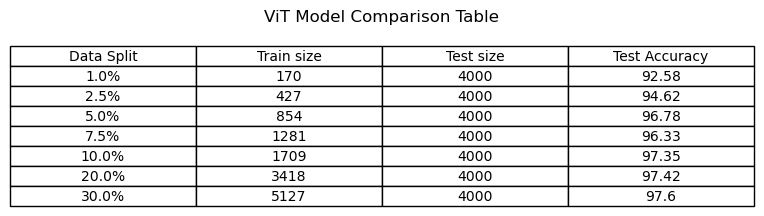

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(test_data)

fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2) 
plt.title('ViT Model Comparison Table', pad=20)
plt.show()

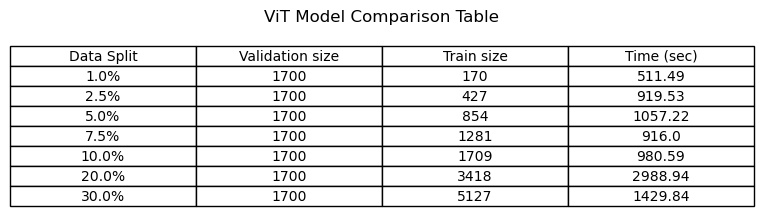

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(time_data)
df = df.drop(["Test size"], axis = 1)
df['Time Taken'] = round(df['Time Taken'], 2)
df.rename(columns={'Time Taken': 'Time (sec)'}, inplace = True)
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2) 
plt.title('ViT Model Comparison Table', pad=20)
plt.show()

In [14]:
def cumulative_list_of_lists(lists):

    for sublist in lists:
        for i in range(1, len(sublist)):
            sublist[i] += sublist[i - 1]
    return lists
cumulative_time_per_epoch = cumulative_list_of_lists(time_per_datasplit_per_epoch)
# print(cumulative_result)

In [15]:
cumulative_time_per_epoch

[[47.50724983215332,
  93.86114931106567,
  143.65740132331848,
  189.35657215118408,
  236.76677870750427,
  283.7749469280243,
  329.9260368347168,
  377.2523055076599,
  424.19755506515503,
  468.1427171230316,
  511.22759461402893],
 [61.57939028739929,
  121.80842232704163,
  183.27014708518982,
  244.7664234638214,
  308.10983395576477,
  368.9558346271515,
  431.01894521713257,
  491.6143743991852,
  552.3517014980316,
  614.5369086265564,
  674.1628992557526,
  735.9018704891205,
  796.8863546848297,
  856.8478305339813,
  919.27778840065],
 [92.56193685531616,
  184.61571073532104,
  275.21363592147827,
  361.2871308326721,
  450.6390767097473,
  535.8267557621002,
  622.6859648227692,
  708.8797695636749,
  796.4575355052948,
  882.7797598838806,
  971.2274904251099,
  1057.075312614441],
 [115.8412172794342,
  230.1490833759308,
  343.8102777004242,
  458.3405041694641,
  575.2481510639191,
  689.0138862133026,
  802.5616898536682,
  915.8285853862762],
 [144.54810619354248,

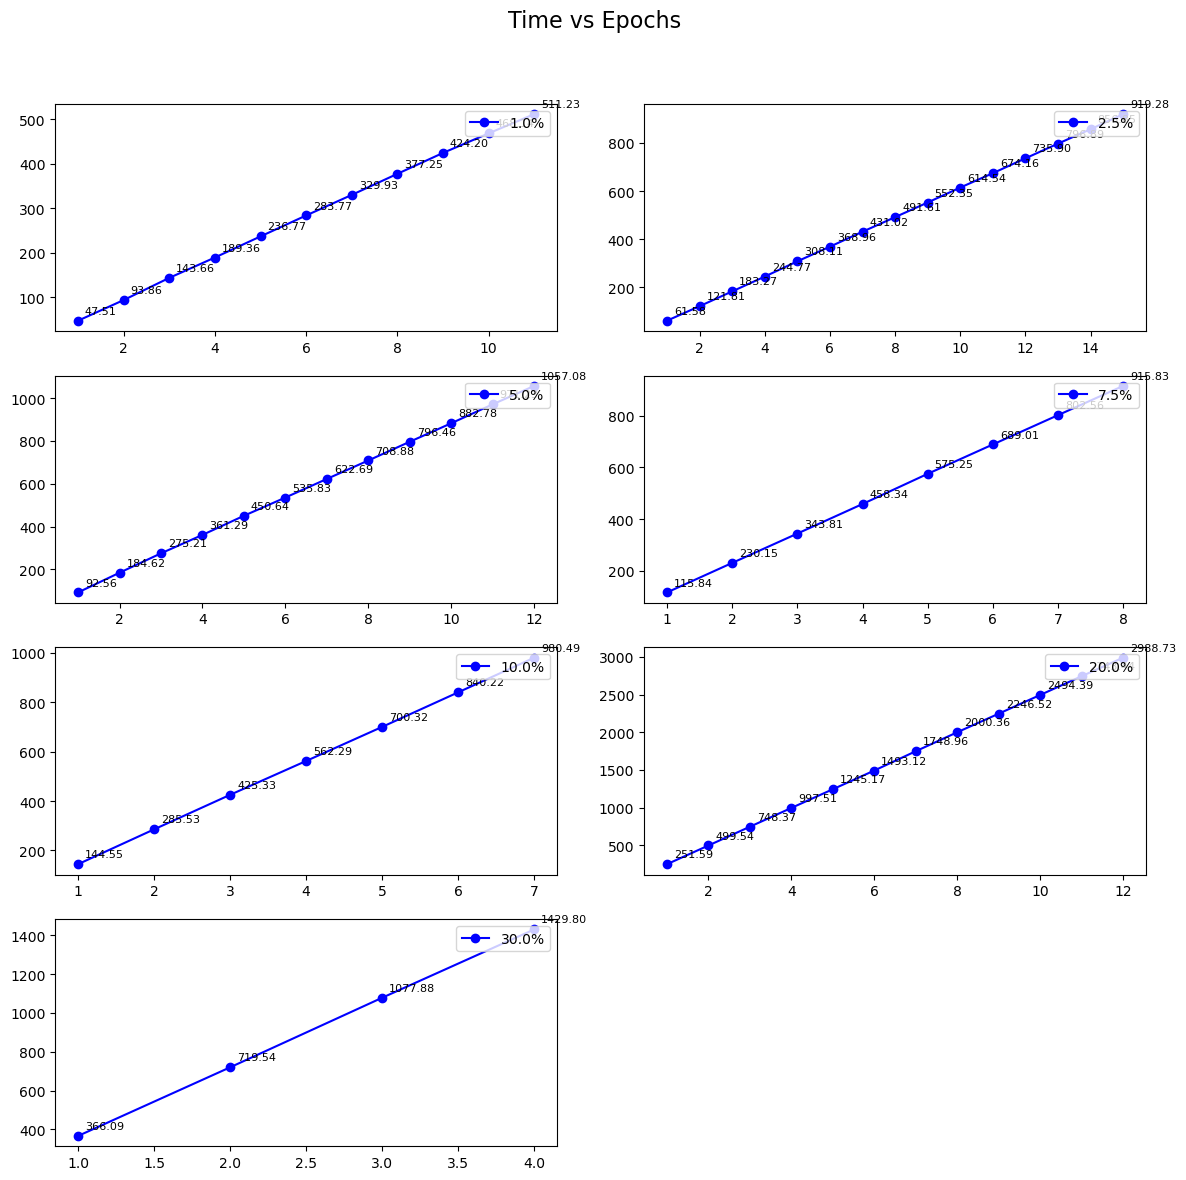

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `cumulative_time_per_epoch` and `dataper` are lists or arrays defined beforehand

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

for i in range(7):
    row = i // 2
    col = i % 2
    x_values = [i for i in range(1, len(cumulative_time_per_epoch[i])+1)]
    y_values = cumulative_time_per_epoch[i]
    
    # Plot the line with markers
    axs[row, col].plot(x_values, y_values, label=f'{dataper[i]*100}%', marker='o', color='b')
    
    # Annotate each point
    for x, y in zip(x_values, y_values):
        axs[row, col].annotate(f'{y:.2f}', xy=(x, y), xytext=(5, 5),
                               textcoords='offset points', fontsize=8, color='black')
    
    # Add legend
    axs[row, col].legend(loc='upper right')

# Hide the last (8th) unused subplot
fig.delaxes(axs[3, 1])
# fig.delaxes(axs[2, 2])
# Add a title and adjust layout
fig.suptitle('Time vs Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()


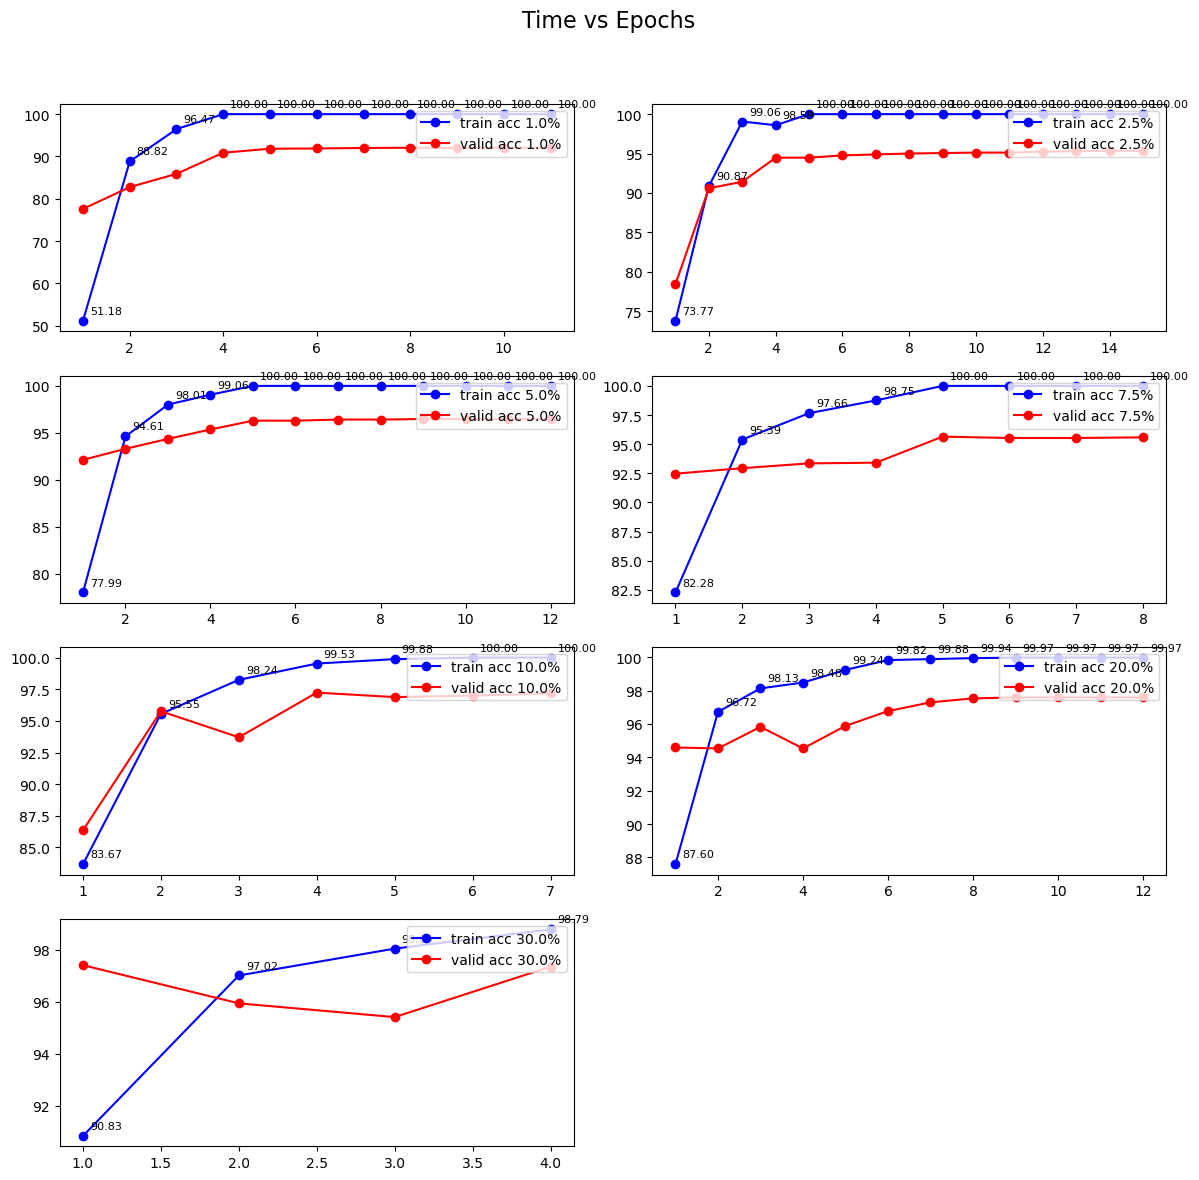

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `cumulative_time_per_epoch` and `dataper` are lists or arrays defined beforehand

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

for i in range(7):
    row = i // 2
    col = i % 2
    x_values = [i for i in range(1, len(cumulative_time_per_epoch[i])+1)]
    y_values = train_acc_all[i]
    
    # Plot the line with markers
    axs[row, col].plot(x_values, y_values, label=f'train acc {dataper[i]*100}%', marker='o', color='b')
    axs[row, col].plot(x_values, val_acc_all[i], label=f'valid acc {dataper[i]*100}%', marker='o', color='r')

    # Annotate each point
    for x, y in zip(x_values, y_values):
        axs[row, col].annotate(f'{y:.2f}', xy=(x, y), xytext=(5, 5),
                               textcoords='offset points', fontsize=8, color='black')
    
    # Add legend
    axs[row, col].legend(loc='upper right')

# Hide the last (8th) unused subplot
fig.delaxes(axs[3, 1])
# fig.delaxes(axs[2, 2])
# Add a title and adjust layout
fig.suptitle('Time vs Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()


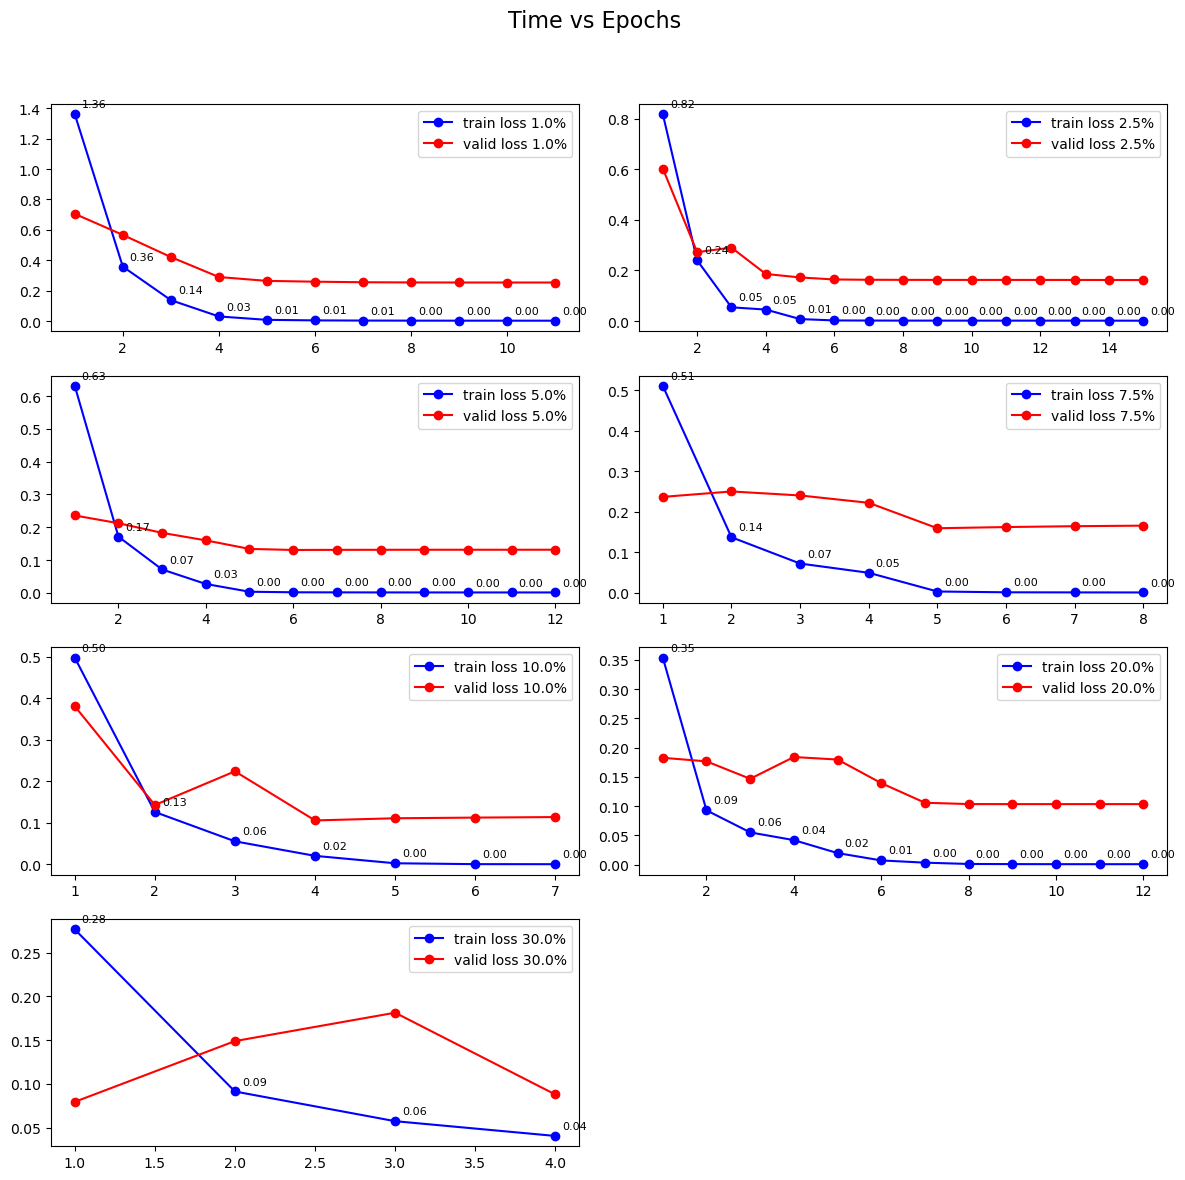

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `cumulative_time_per_epoch` and `dataper` are lists or arrays defined beforehand

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

for i in range(7):
    row = i // 2
    col = i % 2
    x_values = [i for i in range(1, len(cumulative_time_per_epoch[i])+1)]
    y_values = train_loss_all[i]
    
    # Plot the line with markers
    axs[row, col].plot(x_values, y_values, label=f'train loss {dataper[i]*100}%', marker='o', color='b')
    axs[row, col].plot(x_values, val_loss_all[i], label=f'valid loss {dataper[i]*100}%', marker='o', color='r')

    # Annotate each point
    for x, y in zip(x_values, y_values):
        axs[row, col].annotate(f'{y:.2f}', xy=(x, y), xytext=(5, 5),
                               textcoords='offset points', fontsize=8, color='black')
    
    # Add legend
    axs[row, col].legend(loc='upper right')

# Hide the last (8th) unused subplot
fig.delaxes(axs[3, 1])
# fig.delaxes(axs[2, 2])
# Add a title and adjust layout
fig.suptitle('Time vs Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()
